In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install biopython
!pip install codon-bias

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 914.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.4 MB/s eta 0:00:00
  Created wheel for codon-bias: filename=codon_bias-0.3.1-py3-none-any.whl size=26726 sha256=f349bbdf5e0557bea92afc1e01420f00cd0e221fd3c19350bab969b7c1b673c2
  Stored in directory: /root/.cache/pip/wheels/10/86/10/bf084078cbd7b38c3d8937cb3ee2c2950d297ece06b316c48f
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=ee75034633ba670bfbbe65dd59f9de173f309ad5fb484236e80a670470ae1763
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built codon-bias pandarallel


**Data extraction and preparation**

In [ ]:
# Imortant libraries for Biomedical data processing
from Bio import SeqIO
from Bio.SeqUtils import gc_fraction
import codonbias as cb
import pandas as pd
import os


I have kept fatsa formate files in my google drive folder so I have given path of my drive here.
and the folowing code transform fasta sequences from data into CSV file,
after extracting features like. cds ID	cds length	```GC%	ENc	GC1	GC2	GC3```

you can access data from the drive using the link given belowe:
[Link..](https://drive.google.com/drive/folders/1hjrpDzPXkSWNzZ6UluPMfPE3Lz5KrWUE?usp=sharing)

Or you can also work with your desired .fasta or .fa files in your local directory.

In [ ]:

# Directory path containing your FASTA files
fasta_directory = '/content/drive/MyDrive/fasta orgs'

# Iterate through each file in the directory
for filename in os.listdir(fasta_directory):
    if filename.endswith('.fasta') or filename.endswith('.fa'):
        # Construct the full path to the file
        file_path = os.path.join(fasta_directory, filename)

        # Parse the sequences using Biopython's SeqIO
        with open(file_path, 'r') as file:
            # Create a DataFrame for the current organism
            organism_df = pd.DataFrame(columns=['cds ID', 'cds length', 'GC%', 'ENc', 'GC1', 'GC2', 'GC3'])

            for record in SeqIO.parse(file, 'fasta'):
                # Calculate GC percentage
                gc_percentage = gc_fraction(str(record.seq))

                # Calculate ENc
                enc = cb.scores.EffectiveNumberOfCodons() # enc can't be called from module, so explicitly called it
                enc_score = enc.get_score(str(record.seq))

                # Calculate GC1, GC2, GC3
                codon_seq = str(record.seq)
                gc1 = gc_fraction(codon_seq[::3])
                gc2 = gc_fraction(codon_seq[1::3])
                gc3 = gc_fraction(codon_seq[2::3])

                # Append the results to the DataFrame
                organism_df = organism_df.append({
                    'cds ID': record.id.split()[0],
                    'cds length': len(record.seq),
                    'GC%': gc_percentage,
                    'ENc': enc_score,
                    'GC1': gc1,
                    'GC2': gc2,
                    'GC3': gc3
                }, ignore_index=True)

            # Save the DataFrame to a CSV file for the current organism
            output_file_path = os.path.join('/content', f'{filename.split(".")[0]}_result.csv')
            organism_df.to_csv(output_file_path, index=False)


In [ ]:
# Important libraries for Reading data from files, Dimentionality reduction and projecting plots
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


In [ ]:
# Here, I am loading the converted data from fasta_csv folder.
# Path to the directory containing data in CSV files
csv_directory = '/content/drive/MyDrive/fasta_csvs'

# Organism groups
organism_groups = {
    'Aves': ['Apteryx', 'Parus', 'Otus', 'Anas', 'Numida'],
    'Crustacea': ['Penaeus', 'Daphnia', 'Pollicipes', 'Hyalella', 'Lepeophtheirus'],
    'Mammalia': ['Pongo', 'Sarcophilus', 'Ornithorthynchus', 'Ursus', 'Rattus'],
    'Molusca': ['Octupus', 'Lottia', 'Haliotis', 'Crassostrea', 'Mizuhopecten'],
    'Osteichthyes': ['Anabas', 'Cyprinus', 'Cottoperca', 'Esox', 'Denticeps']
}

# Lists to store data for visualization
all_dt_files = []

# Iterate through each CSV file
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Extract the organism's name from the file name
        organism_name = filename.split('_')[0]

        # Determine the group for the current organism
        organism_group = None
        for group, organisms in organism_groups.items():
            if any(organism_name.startswith(prefix) for prefix in organisms):
                organism_group = group
                break

        if organism_group:
            file_path = os.path.join(csv_directory, filename)
            # please remove nrows argument to play with all the data in the files
            df = pd.read_csv(file_path)  # only read 50 rows from each file.

            # Created new columns 'group_name' and 'organism_name' based on the organism group and name
            df['group_name'] = organism_group
            df['organism_name'] = organism_name

            # Append the DataFrame to the list
            all_dt_files.append(df)

            # Print or save the group information
            # print(f"Organism: {organism_name}, Group: {organism_group}") # just for confimation

# Concatinate all DataFrames into a single DataFrame
full_df = pd.concat(all_dt_files, ignore_index=True)
full_df.head()

,cds ID,cds length,GC%,ENc,GC1,GC2,GC3,group_name,organism_name
0,ENSPPYT00000044560.1,285,0.400000,49.616465,0.431579,0.305263,0.463158,Mammalia,Pongo
1,ENSPPYT00000053284.1,324,0.500000,52.732460,0.527778,0.361111,0.611111,Mammalia,Pongo
2,ENSPPYT00000047820.1,336,0.461310,49.022945,0.500000,0.330357,0.553571,Mammalia,Pongo
3,ENSPPYT00000034403.1,285,0.410526,51.506595,0.463158,0.305263,0.463158,Mammalia,Pongo
4,ENSPPYT00000049799.1,336,0.452381,49.653973,0.473214,0.339286,0.544643,Mammalia,Pongo


Below is the data plot which depicts no information about the data sets due to high dimentionality in the data, to katter this problem we have to reduce the dimetions of the data

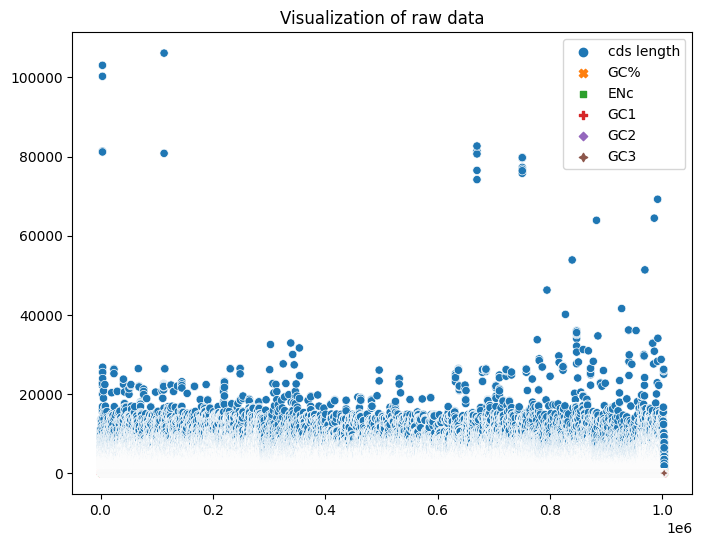

In [ ]:
import seaborn as sns
plt.figure(figsize =(8, 6))
# plt.scatter(full_df['ENc'], full_df['GC3'])
sns.scatterplot(full_df)
# plt.xlabel('ENc')
# plt.ylabel('GC3')
plt.title('Visualization of raw data')
plt.show()

**Selecting features and Standerdising**

Using standard scaling before applying Principal Component Analysis (PCA) is important because PCA is sensitive to the scale of the features. PCA aims to capture the directions of maximum variance in the data, and if the features have different scales, the algorithm might give more weight to features with larger scales

standard scaling helps PCA treat all features equally and ensures that the principal components are not disproportionately influenced by the scale of the original features.

In [ ]:
# Selecting columns for clustering
features = ['cds length', 'GC%', 'ENc', 'GC1', 'GC2', 'GC3']

# Select features for clustering
X = full_df[features]


# scaling the data in certain range
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)


###How to Perform Dimensionality Reduction with PCA?

I have applied PCA to reduce the number of features in our data set. so that most important features could be involved.

####**Principal Components Analysis.**
The steps to perform dimensionality reduction using PCA.

**1. I have fit standardized data using PCA.**

In [ ]:
pca = PCA()
pca.fit_transform(scaled_features)

array([[-2.40640686e+00, -1.36080835e+00,  1.04941267e+00,
         3.62434924e-01, -1.21844815e-01, -7.44598918e-06],
       [-4.35162155e-01, -8.17334886e-01,  2.15081647e-01,
        -8.65251791e-01, -5.27622866e-01, -1.78524595e-05],
       [-9.61139099e-01, -1.16565589e+00,  8.96219900e-01,
        -1.78528686e-01, -3.08921031e-02, -1.19748919e-05],
       ...,
       [-2.26501356e+00, -4.34285276e-01,  7.38490954e-01,
         1.73074757e-01, -1.02968494e-01,  5.17028659e-07],
       [-1.79631771e+00,  2.14801307e-01, -4.01269607e-01,
        -1.82064974e-01,  6.38267633e-01,  3.40791164e-05],
       [-1.79631771e+00,  2.14801307e-01, -4.01269607e-01,
        -1.82064974e-01,  6.38267633e-01,  3.40791164e-05]])

**2. I decided how many features I should keep based on the cumulative variance plot.**

**Q.** *How does this method help in choosing important features?*

 It allows us to identify an inflection point where adding more features provides diminishing returns in terms of capturing variance. The point where the curve starts to flatten can be chosen as the number of features to keep, balancing the trade-off between dimensionality reduction and retaining information.


 * The cumulative explained variance ratio plot illustrates how much of the total variance is explained as we include more principal components.

In [ ]:
pca.explained_variance_ratio_

array([5.18076693e-01, 1.73261256e-01, 1.46053500e-01, 9.68417418e-02,
       6.57667837e-02, 2.56607342e-08])

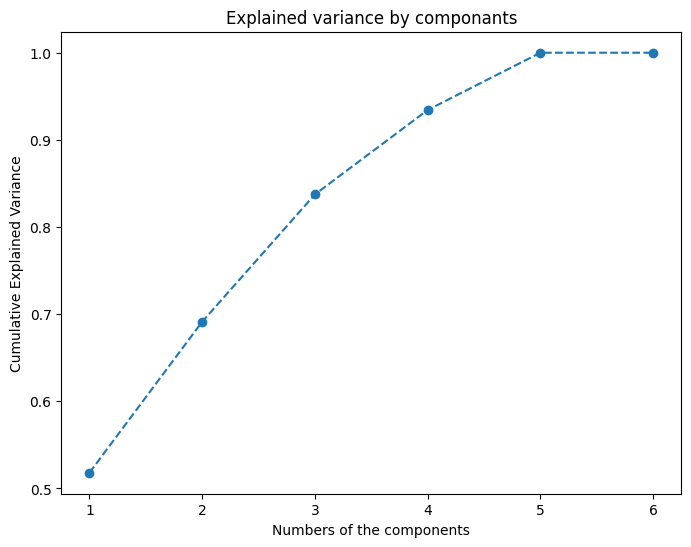

In [ ]:
plt.figure(figsize =(8, 6))
plt.plot(range(1, 7), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Numbers of the components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained variance by componants')
plt.show()

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, I decide to keep 3 components.


**3. I have performed PCA with the chosen number of components.**

For the given data, the means 3 principal components:

In [ ]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)
X_pca = pca.fit_transform(scaled_features)


**Combine PCA and K-means Clustering**

first of all we need to determine the number of clusters in a K-means algorithm.
There are many methods to find the exact numbers of the cluster
Here, I have used renowend Elbow method.


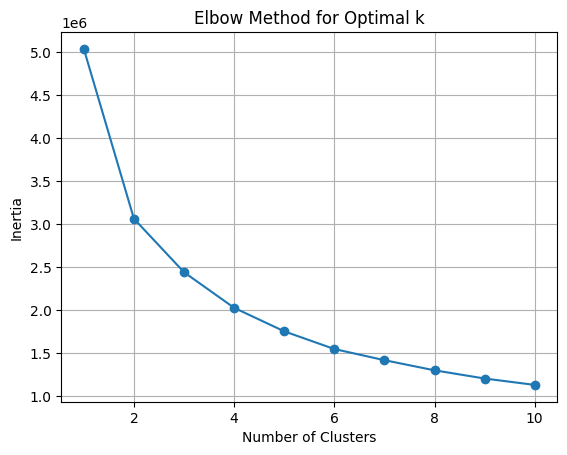

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)  # X is your feature matrix
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


As visible in the above plot, graph fet smother from 5 to onwerd

In [ ]:

# Apply KMeans clustering on the PCA-transformed data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit_predict(X_pca)

array([3, 3, 3, ..., 3, 3, 3], dtype=int32)

In [ ]:
full_df

,cds ID,cds length,GC%,ENc,GC1,GC2,GC3,group_name,organism_name
0,ENSPPYT00000044560.1,285,0.400000,49.616465,0.431579,0.305263,0.463158,Mammalia,Pongo
1,ENSPPYT00000053284.1,324,0.500000,52.732460,0.527778,0.361111,0.611111,Mammalia,Pongo
2,ENSPPYT00000047820.1,336,0.461310,49.022945,0.500000,0.330357,0.553571,Mammalia,Pongo
3,ENSPPYT00000034403.1,285,0.410526,51.506595,0.463158,0.305263,0.463158,Mammalia,Pongo
4,ENSPPYT00000049799.1,336,0.452381,49.653973,0.473214,0.339286,0.544643,Mammalia,Pongo
...,...,...,...,...,...,...,...,...,...
1003268,XM_021497884.1,1011,0.443126,52.163343,0.483680,0.338279,0.507418,Molusca,Mizuhopecten
1003269,XM_021497877.1,1191,0.441646,53.115577,0.478589,0.350126,0.496222,Molusca,Mizuhopecten
1003270,XM_021497027.1,1518,0.410408,51.591147,0.454545,0.328063,0.448617,Molusca,Mizuhopecten
1003271,XM_021516918.1,1806,0.426910,53.246437,0.518272,0.395349,0.367110,Molusca,Mizuhopecten


In [ ]:
segmented_df = pd.concat([full_df.reset_index(drop = True), pd.DataFrame(X_pca)], axis = 1)
segmented_df.columns.values[-3:] = ['PC1', 'PC2', 'PC3']
segmented_df['clusters'] = kmeans.labels_
segmented_df.head()

,cds ID,cds length,GC%,ENc,GC1,GC2,GC3,group_name,organism_name,PC1,PC2,PC3,clusters
0,ENSPPYT00000044560.1,285,0.400000,49.616465,0.431579,0.305263,0.463158,Mammalia,Pongo,-2.406407,-1.360808,1.049413,3
1,ENSPPYT00000053284.1,324,0.500000,52.732460,0.527778,0.361111,0.611111,Mammalia,Pongo,-0.435162,-0.817335,0.215082,3
2,ENSPPYT00000047820.1,336,0.461310,49.022945,0.500000,0.330357,0.553571,Mammalia,Pongo,-0.961139,-1.165656,0.896220,3
3,ENSPPYT00000034403.1,285,0.410526,51.506595,0.463158,0.305263,0.463158,Mammalia,Pongo,-2.268831,-1.150066,0.849314,3
4,ENSPPYT00000049799.1,336,0.452381,49.653973,0.473214,0.339286,0.544643,Mammalia,Pongo,-1.259166,-1.176813,0.721335,3


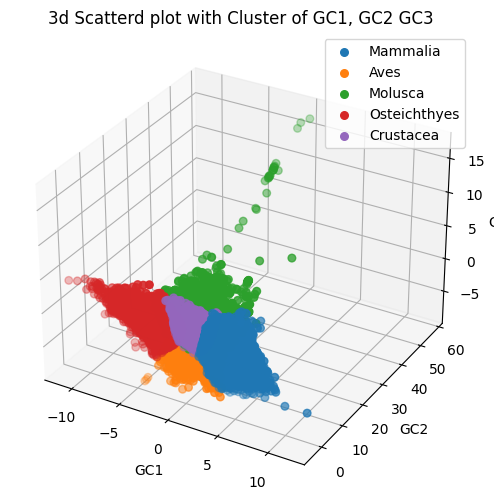

In [ ]:
# Plotting the clusters in 3D space
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')

gn = full_df["group_name"].unique()
for cluster in range(5):
    cluster_data = segmented_df[segmented_df['clusters'] == cluster]
    ax.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        cluster_data['PC3'],
        # label=f'{cluster_data["group_name"].iloc[0]}',
        label=f'{gn[cluster]}',
        s=30
    )

ax.set_xlabel('GC1')
ax.set_ylabel('GC2')
ax.set_zlabel('GC3')
ax.set_title('3d Scatterd plot with Cluster of GC1, GC2 GC3')
# ax.view_init(elev=35, azim=15)
ax.legend()

plt.show()


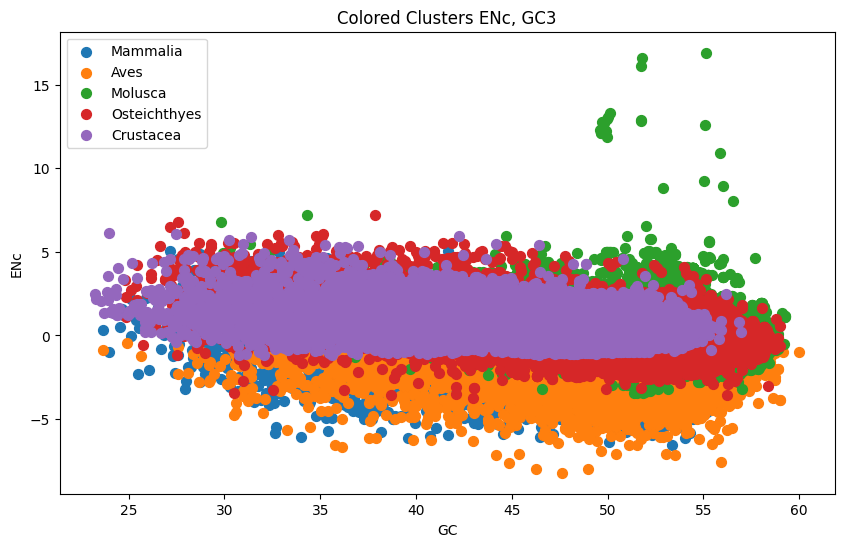

In [ ]:
# Plotting the clusters in 2D space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

gn = full_df["group_name"].unique()
for cluster in range(5):
    cluster_data = segmented_df[segmented_df['clusters'] == cluster]
    ax.scatter(
        cluster_data['ENc'],
        cluster_data['PC3'],
        label=f'{gn[cluster]}',
        s=50
    )

ax.set_xlabel('GC')
ax.set_ylabel('ENc')
ax.set_title('Colored Clusters ENc, GC3')
ax.legend()

plt.show()


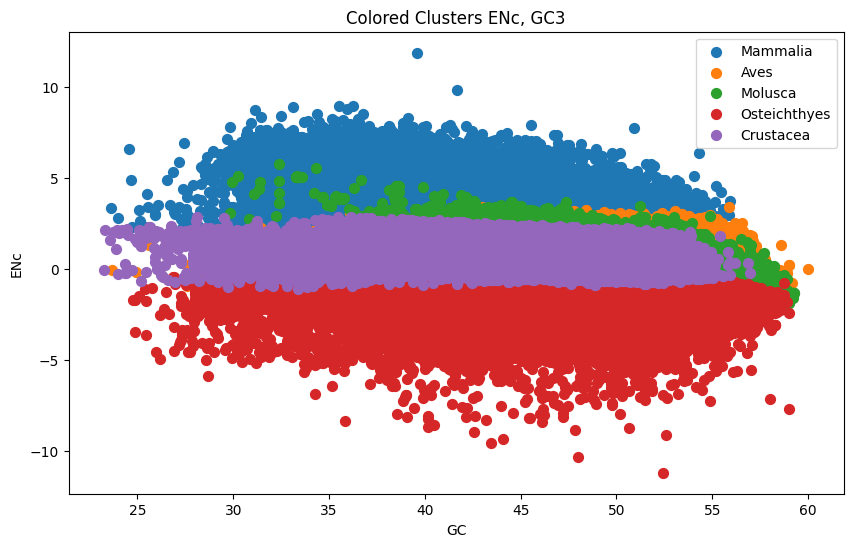

In [ ]:
# Plotting the clusters in 2D space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

gn = full_df["group_name"].unique()
for cluster in range(5):
    cluster_data = segmented_df[segmented_df['clusters'] == cluster]
    ax.scatter(
        cluster_data['ENc'],
        cluster_data['PC1'],
        label=f'{gn[cluster]}',
        s=50
    )

ax.set_xlabel('GC')
ax.set_ylabel('ENc')
ax.set_title('Colored Clusters ENc, GC3')
ax.legend()

plt.show()

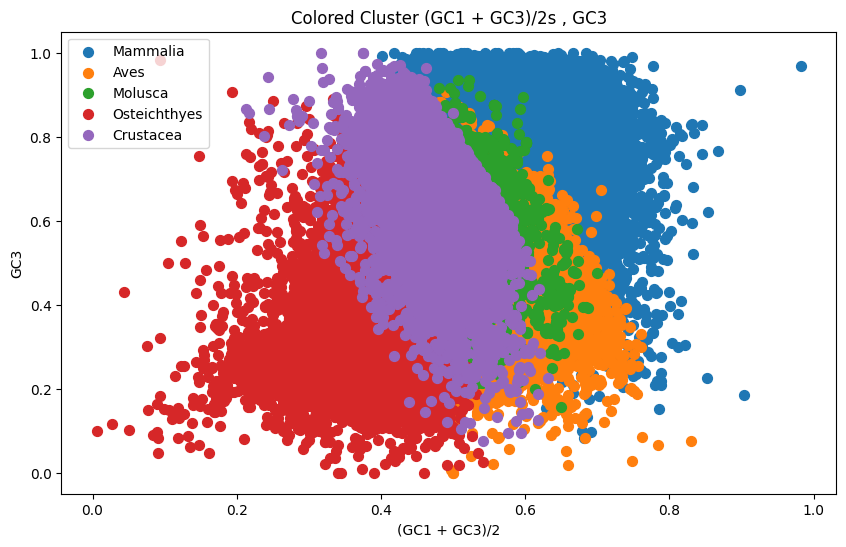

In [ ]:
# Plotting the clusters in 2D space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

gn = full_df["group_name"].unique()
for cluster in range(5):
    cluster_data = segmented_df[segmented_df['clusters'] == cluster]
    ax.scatter(
        (cluster_data['GC1']+cluster_data['GC2'])/2,
        cluster_data['GC3'],
        label=f'{gn[cluster]}',
        s=50
    )

ax.set_xlabel('(GC1 + GC3)/2')
ax.set_ylabel('GC3')
ax.set_title('Colored Cluster (GC1 + GC3)/2s , GC3')
ax.legend()

plt.show()

This report outlines the genomic analysis and clustering performed on a dataset obtained from a biomedical database. The dataset comprises genetic information in the form of coding sequences (CDS) from various organisms. The analysis involves calculating key genomic features, performing dimensionality reduction using PCA, and clustering the data to visualize patterns.

## Data Collection and Pre-processing

#### Data Collection

The genetic information was obtained from a biomedical database using the Biopython library. Sequences were parsed from FASTA files, and relevant features such as CDS ID, CDS length, GC percentage (GC%), Effective Number of Codons (ENc), and codon bias (GC1, GC2, GC3) were calculated.


### Dataset Overview

The dataset consists of records for each CDS, containing information on length, GC content, ENc, and codon bias. Each record is associated with the organism it belongs to.

## Dimensionality Reduction with PCA

Principal Component Analysis (PCA) was applied to reduce the dimensionality of the dataset while preserving the variance. This technique transforms the original features into a set of orthogonal components.

## Clustering Analysis

### Grouping Organisms

Organisms were grouped into categories such as Aves, Crustacea, Mammalia, Molusca, and Osteichthyes based on their names. Each CSV file containing genomic information for a specific organism was processed, and the results were combined into a single DataFrame.

### KMeans Clustering

KMeans clustering was applied to the PCA-transformed features (GC1, GC2, GC3) to identify patterns and group organisms based on their genomic characteristics.

## Visualization

The clustered data was visualized in a 3D space, with each cluster labeled according to the organism group. This visualization provides insights into the genomic similarities and differences among different organism groups.`

## Conclusion


 As we can see that now each species is grouped up into similer group, in the beginning we has seen data was providing no information.
 The analysis and clustering of genomic data have revealed interesting patterns and relationships among different organism groups. The combination of PCA for dimensionality reduction and KMeans clustering allows for a comprehensive exploration of genomic features.

Resources used:
Get data from: https://ftp.ensemblgenomes.ebi.ac.uk/pub/metazoa/release-57/fasta/




Bioinformatics pythone libraries


https://biopython.org/DIST/docs/presentations/Biopython_NextGenBUG_June2009.pdf


https://biopython.org/docs/1.75/api/Bio.SeqUtils.html?highlight=bio%20sequtils#module-Bio.SeqUtils

https://codon-bias.readthedocs.io/en/latest/notebooks/getting_started.html


Tutorials:


https://365datascience.com/tutorials/python-tutorials/pca-k-means/


https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiLv9at-dCDAxWV2gIHHWhqAG8QFnoECAcQAQ&url=https%3A%2F%2Fchat.openai.com%2F&usg=AOvVaw139HWUX4D802zbDuJCdFg9&opi=89978449